# ANALYSIS OF MTOR

This notebook contains an analysis of the mTOR system described in a paper by TM Varusai and LK Nguyen, 2018
(Dynamic modelling of the mTOR signalling network reveals complex emergent behaviours conferred by DEPTOR. 
Varusai TM, Nguyen LK
Scientific reports , 1/ 2018 , Volume 8 , Issue 1 , pages: 643 , PubMed ID: 29330362). The SBML model for this system is in Biomodels, ``BIOMD0000000823``.

We consider a model of the signaling network for mTOR, the mechanistic Target of Rapamycin (mTOR), an evolutionarily conserved network that controls key cellular processes, especially cell growth and metabolism. The signalling cascade is activated by a variety of receptor tyrosine kinases, most notably the Insulin Receptor.

<img src="images/mTOR-System.png"
     alt="Markdown Monster icon" 
     width="500" height="600"
     style="float: left; margin-right: 10px;" />

In [1]:
from controlSBML import ControlSBML

import control
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Problem Statement & System Definition

The biological problem we address is controlling the concentration of phosphorylated ``mTORC1``, ``pmTORC1`. This system has complex dynamics, with both oscillations and bistatility. We want to operate in a region that avoids both. Our control objectives are:
* Regulate ``pmTORC1` to a setpoint
* Fast settling times
* Avoid oscillations

A system is defined by its inputs, outputs, and operating point. The latter refers to the range of inputs over which the system operates. We have specified the output in our problem statement. We need to find an input that regulates ``pmTORC1`` to a setpoint. Further, we need to determine the range of inputs values over which the closed loop system operates since the system behavior may depend on these ranges.

Here is a plot of the floating species.

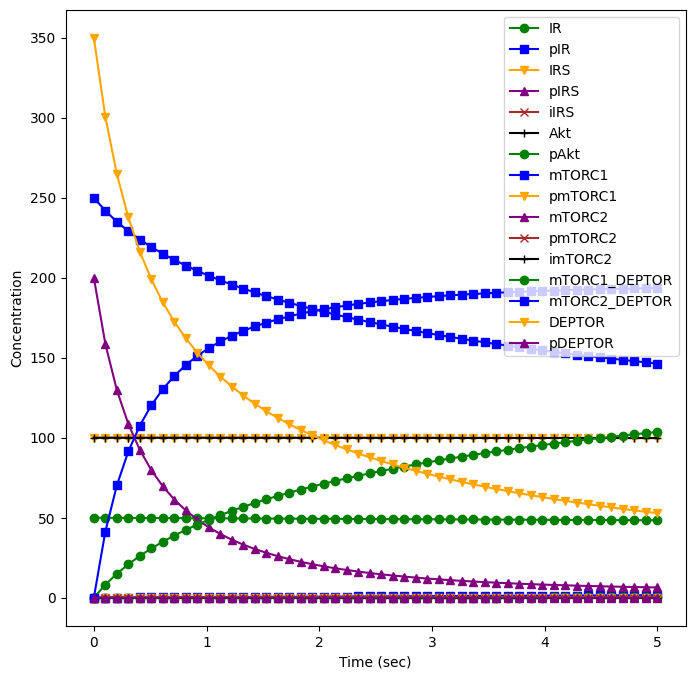

In [2]:
URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL1909250003/2/Varusai2018.xml"
CTLSB = ControlSBML(URL)
_ = CTLSB.plotModel(figsize=(8,8))

We begin by selecting an input. The possible inputs can be determined by creating a ``ControlSBML`` object for the model, and listing candidate inputs.

In [3]:
print(CTLSB.getPossibleInputs())

floating_species:	IR, pIR, IRS, pIRS, iIRS, Akt, pAkt, mTORC1, pmTORC1, mTORC2, pmTORC2, imTORC2, mTORC1_DEPTOR, mTORC2_DEPTOR, DEPTOR, pDEPTOR

parameter:	V1, Km1, V2, Km2, k3c, Km3, V4, Km4, k5ca, Km5a, k5cb, Km5b, V6, Km6, k7c, Km7, V8, Km8, k9c, Km9, V10, Km10, k11ca, Km11a, k11cb, Km11b, V12, Km12, k13f, k13r, k14f, k14r, k15c, Km15, V16, Km16, ks17, kd18


Based on this, we decide to try the phosphorylated insulin receptor, ``pIRS``.

In [4]:
INPUT_NAME = "pIRS"
OUTPUT_NAME = "pmTORC1"
URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL1909250003/2/Varusai2018.xml"
CTLSB = ControlSBML(URL, figsize=(5, 5), times=np.linspace(0, 2000, 20000), markers=False,
                   save_path="data.csv", input_names=[INPUT_NAME], output_names=[OUTPUT_NAME])  # Specify default value of options

We can look at just a subset of the floating specifies by using the output of ``plotModel``.

<Axes: xlabel='miliseconds'>

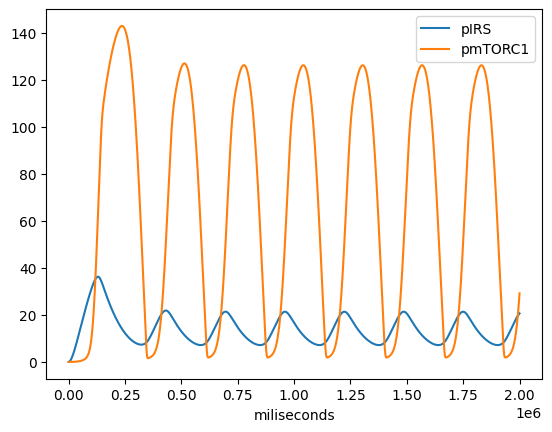

In [5]:
ts = CTLSB.plotModel(is_plot=False)
df = ts[[INPUT_NAME, OUTPUT_NAME]]
seconds = np.array(df.index)/1000
df.index = seconds
df.plot()

The input and output seem to be related. The question is can we *control* the output by varying the input? To anser this question, we construct a *staircase plot*. This plot sets the input to values that are changed during the simulation. We want to see if the output tracks these changes in input.

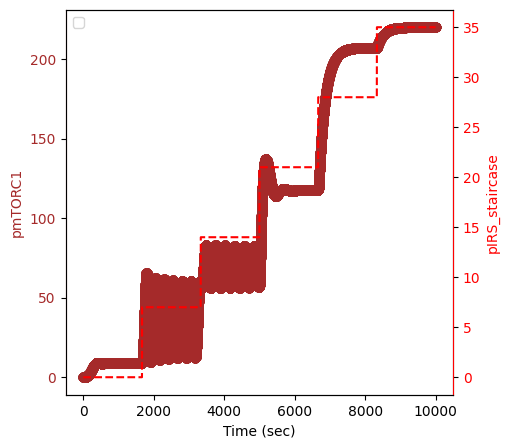

In [6]:
_ = CTLSB.plotStaircaseResponse(initial_value=0, final_value=35, times=np.linspace(0, 10000, 100000))

Clearly, the effect of theinput, pIRS, is effective over only a subset of the range of pIRS. So, we narrow the operating region to interval [20, 25].

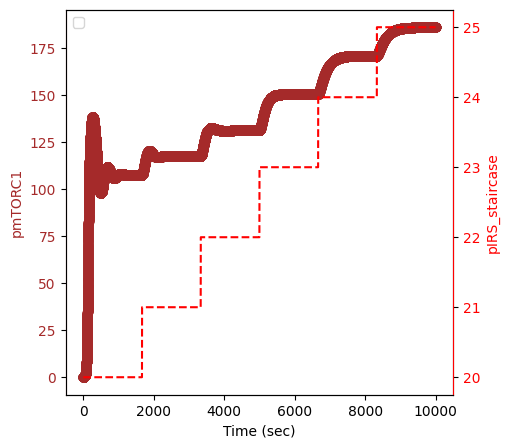

In [7]:
_, builder = CTLSB.plotStaircaseResponse(initial_value=20, final_value=25, times=np.linspace(0, 10000, 100000))

The variable ``builder`` is an ``AntimonyBuilder`` object. ``ControlSBML`` operates by modifying the Antimony source code, and this is done by ``AntimonyBuilder``. Typing the name of the variable produces the Antimony code that is produced. These can be found towards the end, as indicated by the comment lines.

* The system is controllable in the region V1 $>4$, although the control decreases with larger V1 for both complexes.
* The operating region for V1 implies an operating region for pmTORC1 of 180 to 220 and for pmTORC2 0.7 to 1.0.

# 2. System Identification

System identification describes the system as a transfer function for the operating point specified in system definition. In our system, the input is ``pIRS`` and the output is ``pmTORC1``. ``pIRS`` is varied over the operating region of [20, 25]. The method ``plotTransferFunctionFit`` estimates to transfer function and plots the fit. It returns a Timeseries (a dataframe with the data plotted) and an AntimonyBuilder (the Antimony code run to produce the fitting data).

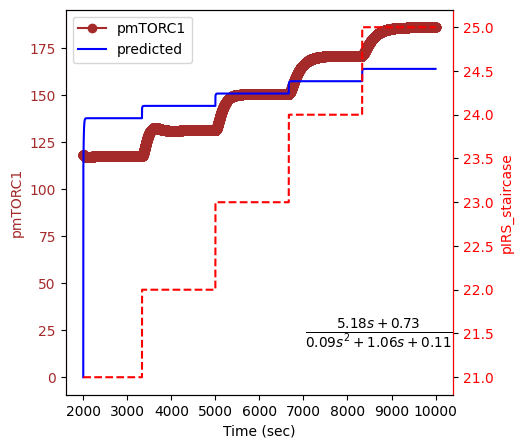

In [9]:
_ = CTLSB.plotTransferFunctionFit(num_numerator=2, num_denominator=3, initial_value=20, final_value=25,
                                  fit_start_time=2000, times=np.linspace(0, 10000, 100000))

We can obtain the transfer function object.

In [10]:
TRANSFER_FUNCTION = CTLSB.getOpenLoopTransferFunction()
TRANSFER_FUNCTION

TransferFunction(array([5.17540964, 0.72799145]), array([0.08670629, 1.05595003, 0.11112446]))

In [11]:
TRANSFER_FUNCTION.poles(), TRANSFER_FUNCTION.zeros()

(array([-12.07230933+0.j,  -0.10616191+0.j]), array([-0.14066354+0.j]))

The very small value of the second pole suggests that we might be able to approximate this system with a one pole model.

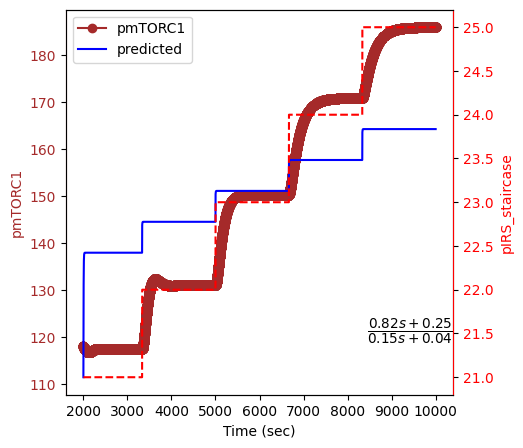

In [12]:
_ = CTLSB.plotTransferFunctionFit(num_numerator=2, num_denominator=2, initial_value=20, final_value=25,
                                  fit_start_time=2000, times=np.linspace(0, 10000, 100000))

In [13]:
CTLSB.getOpenLoopTransferFunction()

TransferFunction(array([0.82216096, 0.2519272 ]), array([0.15485151, 0.03834585]))

In [14]:
tf = CTLSB.getOpenLoopTransferFunction()
tf.poles(), tf.zeros()

(array([-0.24762984+0.j]), array([-0.30642078+0.j]))

The fit is not nearly as good, and the poles and zeroes have much different values. So, we stick with the second order model.

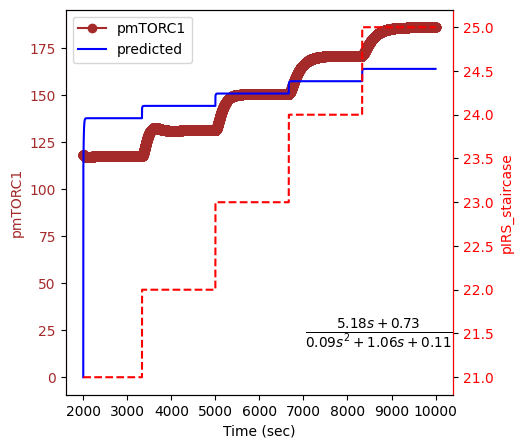

In [15]:
# Recover the previous transfer function
_ = CTLSB.plotTransferFunctionFit(num_numerator=2, num_denominator=3, initial_value=20, final_value=25,
                                  fit_start_time=2000, times=np.linspace(0, 10000, 100000))

# 3. Testbed Construction & Control Design

Here, we build a closed loop system where the open loop is the SBML model of the simulated system. Our has a PI controller.

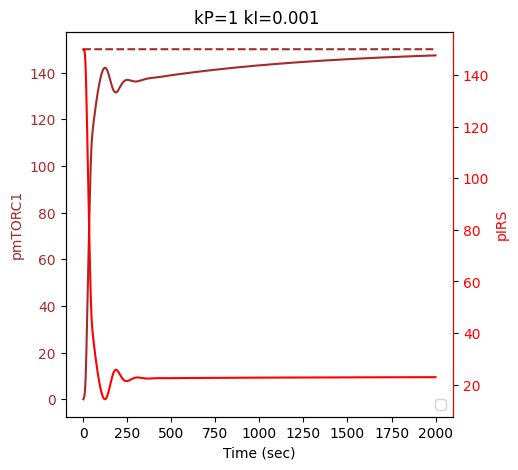

In [20]:
_, builder = CTLSB.plotClosedLoop(setpoint=150, kP=1, kI=0.001, kF=None)

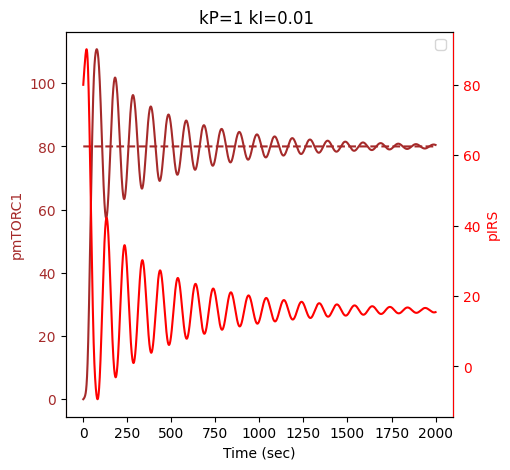

In [22]:
_ = CTLSB.plotClosedLoop(setpoint=80, kP=1, kI=0.01, kF=None)

We are able to simulate the closed loop system, but it's not easy to find design parameters that meet our control objectives.

Here we introduce capabilities of ``controlSBML`` that aid in design

One approach is to use design techniques for linear time-invariant (LTI) systems, such as root locus plots or frequency methods. Since we have a transfer function for the open loop system (obtained when we did System Identification), these techniques are available to us via the rich capabilities of the Python Control Systems Library.

The root locus plot shows how poles of the closed loop system change when using proportional control. From system identification, we know that the transfer function is

In [23]:
TRANSFER_FUNCTION

TransferFunction(array([5.17540964, 0.72799145]), array([0.08670629, 1.05595003, 0.11112446]))

The zeros and poles are shown below. Note that the zero is very close to one pole, and so we essentially have pole-zero cancelation.

In [24]:
TRANSFER_FUNCTION.zeros(), TRANSFER_FUNCTION.poles()

(array([-0.14066354+0.j]), array([-12.07230933+0.j,  -0.10616191+0.j]))

The root locus plot shows the position of poles as $k_P$ goes from zero to $\infty$. Closed loop poles start at an open loop pole with $k_P = 0$. 
As $k_P$ gets larger, closed loop poles moved to closed loop zeros, which may be at infinity (as is the case for the "branch" from the smaller pole).

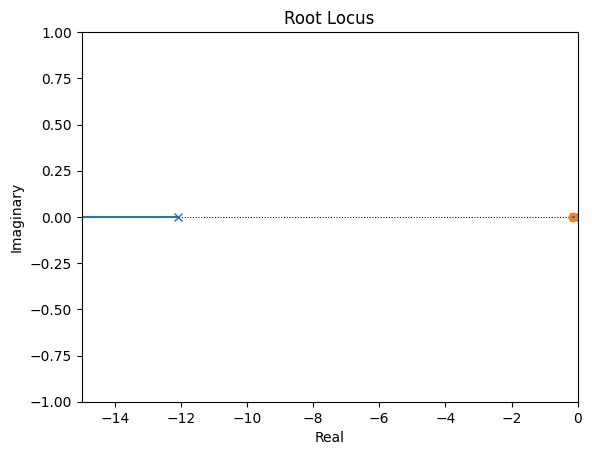

In [25]:
_ = control.rlocus(TRANSFER_FUNCTION, xlim=[-15, 0], grid=False)

The root locus plot indicates that the identified transfer function is stable and should not oscillate (since all poles are real) when considered in a closed loop system, even for large $k_P$. However, we emphasize that this is only an approximation to the nonlinear ``mTOR`` system. As shown below, $k_P$, we see substantial oscillations. The system becomes unstable if $k_P > 3$.

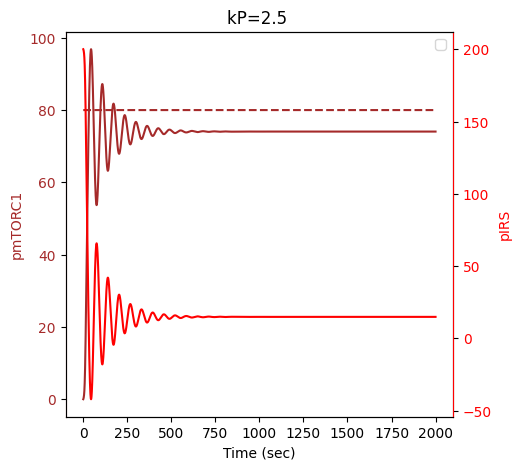

In [26]:
_ = CTLSB.plotClosedLoop(setpoint=80, kP=2.5, kI=None, kF=None)

To address the shortcomings of linear approximation,
``controlSBML`` provides a grid search to help in these circumstances. A grid search is a search in an n-dimensional space where each point in the space is a candidate to evaluate. In our case, a candidate is a possible design of the closed loop system. The design is specified by values of $k_P$, $k_I$, and/or $k_F$. The possible values of each parameter are points along an axis in the grid. Selecting one value from each grid defines a point in the design space. ``controlSBML`` searches all points in the grid space and returns one that produces a time course that is closest to the setpoint.

In [27]:
#
# Grid search for a proportional controller
#
# Get the grid when there is only one parameter. There will be 100 values on the axis. Values are evenly spaced (is_random=False).
grid = CTLSB.getGrid(kP_spec=True, kI_spec=False, num_coordinate=100, is_random=False)
axis = grid.getAxis("kP")
# Specify the smallest value on the axis
axis.setMinValue(0.1)
# Specify the highest value on the axis
axis.setMaxValue(10)
# Search. Save the search results in "data1.csv"
ts, builder = CTLSB.plotGridDesign(grid, setpoint=120, save_path="data1.csv")

  0%|          | 0/100 [00:00<?, ?it/s]
Process Process-2:
Traceback (most recent call last):
  File "/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/point_evaluator.py", line 75, in _calculateMse
    response_ts, _ = self.sbml_system.simulateSISOClosedLoop(setpoint=self.setpoint,
TypeError: simulateSISOClosedLoop() got an unexpected keyword argument 'kP'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/parallel_search.py", line 152, in _evaluateCandidates
   

``controlSBML`` does this search in parallel and provides a progress bar. The degree of parallelism depends on the number of cores available.

The above plot displays the "best"" design in that it has the smallest mean-square-error (MSE) with respect to the setpoint, and there are no negative concentrations. We can see all feasible designs (e.g., excluding those that are unstable) by plotting the design result.

In [28]:
CTLSB.plotDesignResult(figsize=(5,5), title="One Parameter Designs", save_path="data1.csv")

(None, None)

We now explore designs for PI controllers.

In [29]:
grid = CTLSB.getGrid(kP_spec=True, kI_spec=True, num_coordinate=11, is_random=False)
axis = grid.getAxis("kP")
axis.setMinValue(0.1)
axis.setMaxValue(2)
axis = grid.getAxis("kI")
axis.setMinValue(0.01)
axis.setMaxValue(0.02)
ts, builder = CTLSB.plotGridDesign(grid, setpoint=120, save_path="data2.csv")

  0%|          | 0/100 [00:00<?, ?it/s]
Process Process-13:
Traceback (most recent call last):
  File "/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/point_evaluator.py", line 75, in _calculateMse
    response_ts, _ = self.sbml_system.simulateSISOClosedLoop(setpoint=self.setpoint,
TypeError: simulateSISOClosedLoop() got an unexpected keyword argument 'kP'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/parallel_search.py", line 152, in _evaluateCandidates
  

Since we have two design parameters, we visualize the results of the grid search using a heatmap where the color of the cell represents its mean squared error.

In [30]:
CTLSB.plotDesignResult(figsize=(5,5), save_path="data2.csv", title="Two Parameter Design")

(None, None)

Below is an illustration of a design that is a PI controller with a filter. Note that the number of points in the design space grows multiplicatively with the number of design parameter.

In [31]:
grid = CTLSB.getGrid(kP_spec=True, kI_spec=True, kF_spec=True, num_coordinate=11, is_random=False)
axis = grid.getAxis("kP")
axis.setMinValue(1.5)
axis.setMaxValue(1.9)
axis.setNumCoordinate(11)
axis = grid.getAxis("kI")
axis.setMinValue(0.001)
axis.setMaxValue(0.009)
axis.setNumCoordinate(11)
axis = grid.getAxis("kF")
axis.setMinValue(0.001)
axis.setMaxValue(0.002)
axis.setNumCoordinate(11)
ts, builder = CTLSB.plotGridDesign(grid, setpoint=120, num_restart=1, is_greedy=False, is_report=True, 
                                   save_path="data3.csv")

ValueError: Invalid kwargs: {'is_report'}

The resulting design is not as good as the PI controller. This is reflected in the MSE values being about ten times larger than those for the PI design without a filter.

In [ ]:
CTLSB.plotDesignResult(save_path="data3.csv", suptitle="Three Parameter Design", figsize=(8,8))